In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import csv
import time

# ------------------- Setup Chrome -------------------
chrome_options = Options()
chrome_options.add_argument("--start-maximized")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")

driver = webdriver.Chrome(options=chrome_options)
all_products = []

print("Starting scraper...\n")

# ------------------- Go to Amazon -------------------
driver.get("https://www.amazon.in/s?k=face+cream")
time.sleep(4)

# ------------------- Scrape multiple pages -------------------
for page_num in range(1, 3):
    print(f"Scraping Page {page_num}...")
    time.sleep(3)
    
    # Find all product elements on the current page
    products = driver.find_elements(By.CSS_SELECTOR, "div.s-main-slot div.s-result-item")

    print(f"Found {len(products)} products on Page {page_num}")

    # ------------------- Loop through each product -------------------
    for product in products:
        # Product Name
        name_elements = product.find_elements(By.CSS_SELECTOR, "h2 span")
        name = name_elements[0].text if name_elements else "N/A"
        
        # Selling Price
        price_elements = product.find_elements(By.CSS_SELECTOR, "span.a-price-whole")
        selling_price = price_elements[0].text if price_elements else "N/A"
        
        # Discount Percentage
        discount_elements = product.find_elements(By.CSS_SELECTOR, "span.a-letter-space + span")
        discount = discount_elements[0].text if discount_elements else "N/A"
        
        # Monthly Purchases (e.g., "1K+ bought in past month")
        purchase_elements = product.find_elements(By.CSS_SELECTOR, "span.a-size-base.a-color-secondary")
        monthly_purchases = "N/A"
        for elem in purchase_elements:
            text = elem.text
            if "bought" in text.lower() or "k+" in text.lower():
                monthly_purchases = text
                break
        
        # Save data (only if name exists)
        if name != "N/A":
            product_data = {
                'Product Name': name,
                'Selling Price': selling_price,
                'Discount': discount,
                'Monthly Purchases': monthly_purchases,
                'Page Number': page_num
            }
            all_products.append(product_data)
    
    # ------------------- Go to next page -------------------
    if page_num < 2:
        next_button = driver.find_elements(By.CSS_SELECTOR, "a.s-pagination-next")
        if next_button:
            next_button[0].click()
            time.sleep(3)
        else:
            print("Cannot find next page button")
            break

# ------------------- Save to CSV -------------------
print(f"\nTotal products scraped: {len(all_products)}")
print("Saving to CSV...")

csv_filename = 'amazon_face_cream.csv'
with open(csv_filename, 'w', newline='', encoding='utf-8') as file:
    fieldnames = ['Product Name', 'Selling Price', 'Discount', 'Monthly Purchases', 'Page Number']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_products)

print(f"✓ Saved to {csv_filename}")

time.sleep(3)
driver.quit()
print("Done!")


Starting scraper...

Scraping Page 1...
Found 67 products on Page 1
Scraping Page 2...
Found 79 products on Page 2

Total products scraped: 132
Saving to CSV...
✓ Saved to amazon_face_cream.csv
Done!


In [1]:
# Popularity Classification Model using Logistic Regression

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
import re

# Load and Inspect Data
df = pd.read_csv("amazon_face_cream.csv")

# Replace missing values
df = df.replace("N/A", np.nan).fillna("0")

# Clean Numeric Columns
# Convert Selling Price to numeric
df["Selling Price"] = df["Selling Price"].replace(r"[^\d]", "", regex=True).astype(int)

# Extract numeric discount (remove %, brackets, etc.)
df["Discount"] = df["Discount"].replace(r"[^\d]", "", regex=True)
df["Discount"] = pd.to_numeric(df["Discount"], errors="coerce").fillna(0).astype(int)

# Extract numeric monthly purchases
def extract_purchases(text):
    if isinstance(text, str):
        match = re.search(r"(\d+(\.\d+)?)(K)?", text)
        if match:
            num = float(match.group(1))
            if match.group(3) == "K":
                num *= 1000
            return int(num)
    return 0

df["Monthly_Purchases_Numeric"] = df["Monthly Purchases"].apply(extract_purchases)

# Define Target Variable (Popularity)
# Threshold = 5000 monthly purchases
df["Popularity"] = df["Monthly_Purchases_Numeric"].apply(lambda x: 1 if x > 5000 else 0)

# Feature Extraction
# TF-IDF on Product Name (text data)
vectorizer = TfidfVectorizer(max_features=300, stop_words="english")
X_text = vectorizer.fit_transform(df["Product Name"])

# Combine text + numeric features
X_numeric = df[["Selling Price", "Discount"]].values
X = hstack([X_text, X_numeric])

y = df["Popularity"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)

print("Model Evaluation Results")
print("-" * 35)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Top text features influencing popularity
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_[0][:len(feature_names)]  # Only text features

top_positive = np.argsort(coef)[-10:][::-1]
print("\nTop keywords indicating Popular products:")
for i in top_positive:
    print(f"  {feature_names[i]} -> {coef[i]:.4f}")

Model Evaluation Results
-----------------------------------
Accuracy: 0.72

Top keywords indicating Popular products:
  hydration -> 0.9852
  free -> 0.6472
  gel -> 0.6392
  superlight -> 0.6214
  moisturizer -> 0.6083
  vegan -> 0.6008
  plum -> 0.5768
  oil -> 0.5766
  dermat -> 0.5715
  brightens -> 0.5592


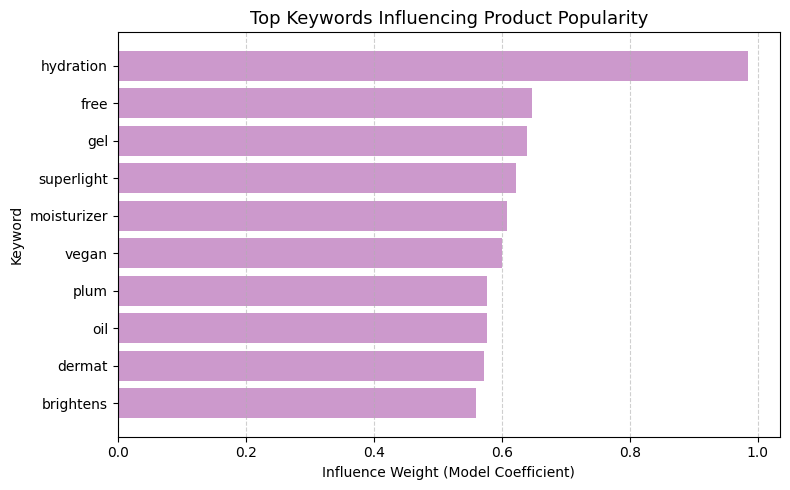

In [12]:
# Visualizing Keyword Importance
import matplotlib.pyplot as plt

# Create a DataFrame of top features
top_features = pd.DataFrame({
    'Keyword': [feature_names[i] for i in top_positive],
    'Weight': [coef[i] for i in top_positive]
})

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.barh(top_features['Keyword'], top_features['Weight'], color='purple', alpha=0.4)
plt.gca().invert_yaxis()  # Highest weight on top
plt.title("Top Keywords Influencing Product Popularity", fontsize=13)
plt.xlabel("Influence Weight (Model Coefficient)")
plt.ylabel("Keyword")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
